In [1]:
%reload_ext autoreload
%autoreload 2

# Mahakala

In [32]:
import mahakala as ma
from mahakala.geodesics import Nullify, metric, get_camera_pixel, get_initial_grid, initial_condition
import numpy as np
import matplotlib.pyplot as plt

cpu


## Geodesic trajectories
example demo showing the geodesic trajectories for a non-spinning black hole

In [9]:
bhspin = 0.0 # the spin of the black hole, this works best for zero spin
lim = 15 # the maximum impact parameter of photons in this example
spacing = 60 # the spacing between photon impact parameters

# initialize the photons along the equator
s0 = ma.initialize_geodesics_at_camera(bhspin,60,1000,-lim,lim,spacing,camera_type='Equator')


In [10]:
# run the geodesic integrator
S,final_dt = ma.geodesic_integrator(10000,s0,40,1e-4, bhspin)
S.shape

  8%|███                                   | 818/10000 [00:01<00:18, 507.37it/s]


(819, 60, 8)

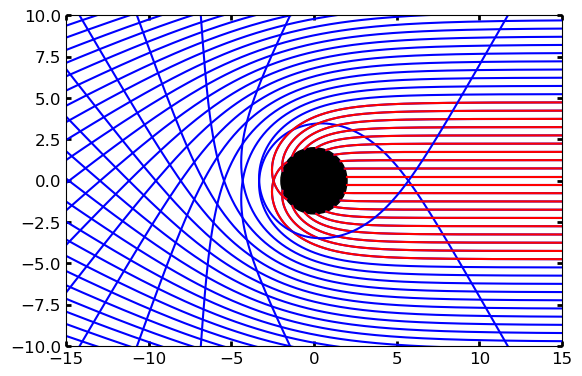

In [61]:
# make the plot of the geodesic trajectories, red photons fall into BH
for i in range(np.shape(S)[1]):
    x = S[:,i,1]
    y = S[:,i,2]
    plt.plot(x,y, c='blue')
    if np.min(np.sqrt(x*x + y*y)) < 2.01:
        plt.plot(x,y, c='red')

plt.ylim([-lim/1.5,lim/1.5])
plt.xlim([-lim,lim])
plt.gca().set_aspect('equal')
circ1 = plt.Circle((0,0), radius=2, color='k', fill=True)
plt.gca().add_patch(circ1)
plt.gca().tick_params(axis='both', which='both', labelsize=12,width=2,direction='in', right=True, top=True,color='k') 


In [6]:
# def init_cond2(s0_x, s0_v, bhspin):
#     '''
#     !@brief This function returns the correct initial null goedesic conditions for the grid of photons
#     '''

#     nullify = Nullify(metric, bhspin)

#     s0 = []
#     for i in range(len(s0_x.T)):
#         v = nullify(s0_x[:,i],s0_v[:,i])
#         s0.append(np.concatenate([s0_x[:,i],v]))

#     s0 = np.array(s0)
#     return s0

In [59]:
# def initial_grid2(i,d,ll,ul,spacing,Type):
#     '''
#     !@brief Defines the initial grid of photons that will be thrown towards the Black hole

#     @param i This is the inclination of the observer relative to the black hole in degrees.

#     @param d It is the initial distance of the image from the Black hole centre

#     @param ll This is the lower limit of the grid

#     @param ul This is the upper limit of the grid

#     @param equatorial Takes in a boolean value. If True, only photons in the equatorial plane will be initialised with the limits of Impact parameter = ll and ul. If False, defines a grid of photons

#     @return s0_x,s0_v Where s0_x is array containing the position 4-vector of all the photons. s0_v contains the velocity 4-vector of all the photons
#     '''

#     if Type == 'Grid':

#         grid_list = np.linspace(ll,ul,2 * spacing + 1)[1::2]

#         z = 0 * jnp.ones(len(grid_list)**2)

#         x,y = jnp.meshgrid(grid_list,grid_list,indexing = 'ij')

#         x = x.flatten()
#         y = y.flatten()

#         origin_BH = Image_to_BH(0,0,0,i,d)
#         temp_coord = perpendicular([x,y])

#         init_BH = Image_to_BH(x,y,z,i,d)
#         perp_BH = Image_to_BH(temp_coord[0],temp_coord[1],0 * jnp.ones(len(grid_list)**2),i,d)

#         vec1 = - (init_BH.T - origin_BH)
#         vec2 = (perp_BH - init_BH)

#         k_vec = np.cross(vec1,vec2.T)
#         s0_x = np.array([0 * np.ones(len(grid_list)**2),init_BH[0].flatten(), init_BH[1].flatten(), init_BH[2].flatten()])
#         s0_v = np.array([1 * np.ones(len(grid_list)**2),k_vec.T[0].flatten(), k_vec.T[1].flatten(), k_vec.T[2].flatten()])

#         return s0_x,s0_v

#     elif Type == 'Equator':
#         grid_list = jnp.arange(ll,ul,spacing)

#         s0 = jnp.zeros(8)

#         s0_x = np.zeros((4,len(grid_list)))

#         s0_x[1,:] = d
#         s0_x[2,:] = grid_list

#         s0_v = np.ones((4,len(grid_list)))

#         s0_v[2,:] = 0
#         s0_v[3,:] = 0

#         return s0_x,s0_v

#     else:
#         pass

In [60]:
# def initialize_geodesics_at_camera2(i,d,ll,ul,spacing,TYPE, bhspin):
#     '''
#     @ Brief This function generates an initial grid of photons that are then used for the geodesic integrator.

#     @ dependencies: This function depends on the following functions,
#     Nullify(metric, p=1)
#         quadratic(A, b, C)
#         metric(x)

#     initial_grid(i,d,ll,ul,spacing,Type)
#         meshgrid
#         Image_to_BH(x,y,z,i,d)
#         perpendicular( a )

#     init_cond(s0_x,s0_v)
#         Nullify(metric, p=1)
#             quadratic(A, b, C)
#             metric(x)
#     '''
#     '''
#     Initilializes the image plane.

#     i - inclination (in degrees)
#     d - distance of the image from the black hole (in code units)
#     ll - lower limit of the image plane
#     ul - upper limit of the image plane
#     spacing - number of photons between ul and ll
#     TYPE - it's either GRID (for 3-D visualization) or Equator (for photons along the equatorial cross-section)
#     '''

#     s0_x, s0_v = initial_grid2(i,d,5,5,1,TYPE)

#     return init_cond2(s0_x, s0_v, bhspin)

In [12]:
import numpy as np
from tqdm import tqdm

from jax import numpy as jnp
from jax import jit, jacfwd, vmap
from jax.numpy import dot
from jax.numpy.linalg import inv
##### This will tell whether we are using CPU or GPU #########
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [57]:
def integrate_one_photon(N_time_steps, angle, radius, bhspin, distance = 1000):
    s0_x, s0_v = get_camera_pixel(0,distance,radius,0)
    init_one = initial_condition(s0_x, s0_v, angle)
    print(init_one)
    S,final_dt = ma.geodesic_integrator(N_time_steps,init_one,40,1e-4, bhspin)
    x = S[:,0,1]
    y = S[:,0,2]
    return(x, y)
#     return(np.min(np.sqrt(x*x + y*y)))
#     return(np.sqrt(x*x + y*y)) # returns final distance from BH

In [53]:
def bisection_shadow(bhspin, angle, N_time_steps = 1000):
    inner = 2
    outer = 8
    err = outer - inner
    while err > 0.01:
        final_inn = integrate_one_photon(N_time_steps, angle, inner, bhspin)
        final_out = integrate_one_photon(N_time_steps, angle, outer, bhspin)
        final_mid = integrate_one_photon(N_time_steps, angle, (outer-inner)/2+inner, bhspin)
        if final_mid < 2.1:
            print("help! I've fallen in!")
            inner = (outer-inner)/2+inner
        else: outer = (outer-inner)/2+inner
        err = outer - inner
    return(inner)


In [58]:
x, y = integrate_one_photon(1000, 0.0, 0.1, 0.0)

[[ 0.000000e+00  0.000000e+00  1.000000e-01  1.001000e+03  1.000000e+00
   7.045379e-01 -7.045379e-01  7.045380e-02]]


  4%|█▋                                     | 42/1000 [00:00<00:00, 2680.96it/s]


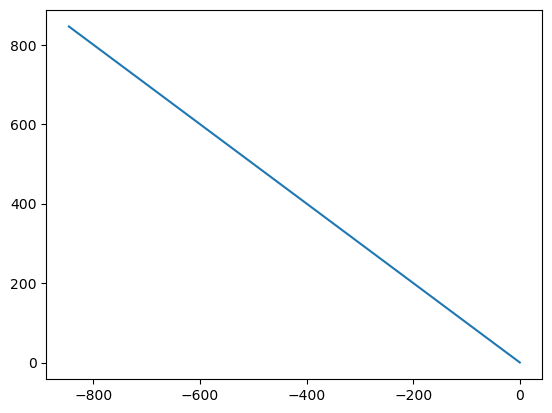

In [59]:
plt.plot(x,y)


In [50]:
distance = bisection_shadow(0.0, 0.0)
distance

[[ 0.0000000e+00  0.0000000e+00  2.0000000e+00  1.0010000e+03
   1.0000000e+00  4.0690553e-01 -4.0690553e-01  8.1381106e-01]]


 11%|████▎                                 | 112/1000 [00:00<00:00, 2819.11it/s]


[[ 0.0000000e+00  0.0000000e+00  8.0000000e+00  1.0010000e+03
   1.0000000e+00  1.2260855e-01 -1.2260855e-01  9.8086840e-01]]


 21%|████████                              | 212/1000 [00:00<00:00, 2904.42it/s]


[[ 0.0000000e+00  0.0000000e+00  5.0000000e+00  1.0010000e+03
   1.0000000e+00  1.9171192e-01 -1.9171192e-01  9.5855957e-01]]


 18%|██████▋                               | 176/1000 [00:00<00:00, 2925.63it/s]


[[ 0.0000000e+00  0.0000000e+00  2.0000000e+00  1.0010000e+03
   1.0000000e+00  4.0690553e-01 -4.0690553e-01  8.1381106e-01]]


 11%|████▎                                 | 112/1000 [00:00<00:00, 2898.92it/s]


[[ 0.0000000e+00  0.0000000e+00  5.0000000e+00  1.0010000e+03
   1.0000000e+00  1.9171192e-01 -1.9171192e-01  9.5855957e-01]]


 18%|██████▋                               | 176/1000 [00:00<00:00, 2963.41it/s]


[[ 0.0000000e+00  0.0000000e+00  3.5000000e+00  1.0010000e+03
   1.0000000e+00  2.6392627e-01 -2.6392627e-01  9.2374188e-01]]


 15%|█████▋                                | 150/1000 [00:00<00:00, 2925.52it/s]


[[ 0.0000000e+00  0.0000000e+00  2.0000000e+00  1.0010000e+03
   1.0000000e+00  4.0690553e-01 -4.0690553e-01  8.1381106e-01]]


 11%|████▎                                 | 112/1000 [00:00<00:00, 2913.87it/s]


[[ 0.0000000e+00  0.0000000e+00  3.5000000e+00  1.0010000e+03
   1.0000000e+00  2.6392627e-01 -2.6392627e-01  9.2374188e-01]]


 15%|█████▋                                | 150/1000 [00:00<00:00, 2917.44it/s]


[[ 0.0000000e+00  0.0000000e+00  2.7500000e+00  1.0010000e+03
   1.0000000e+00  3.2223058e-01 -3.2223058e-01  8.8613409e-01]]


 13%|█████                                 | 133/1000 [00:00<00:00, 2913.61it/s]


[[ 0.0000000e+00  0.0000000e+00  2.0000000e+00  1.0010000e+03
   1.0000000e+00  4.0690553e-01 -4.0690553e-01  8.1381106e-01]]


 11%|████▎                                 | 112/1000 [00:00<00:00, 2915.82it/s]


[[ 0.0000000e+00  0.0000000e+00  2.7500000e+00  1.0010000e+03
   1.0000000e+00  3.2223058e-01 -3.2223058e-01  8.8613409e-01]]


 13%|█████                                 | 133/1000 [00:00<00:00, 2927.20it/s]


[[ 0.0000000e+00  0.0000000e+00  2.3750000e+00  1.0010000e+03
   1.0000000e+00  3.6052620e-01 -3.6052620e-01  8.5624975e-01]]


 12%|████▋                                 | 123/1000 [00:00<00:00, 2922.23it/s]


[[ 0.0000000e+00  0.0000000e+00  2.0000000e+00  1.0010000e+03
   1.0000000e+00  4.0690553e-01 -4.0690553e-01  8.1381106e-01]]


 11%|████▎                                 | 112/1000 [00:00<00:00, 2919.03it/s]


[[ 0.0000000e+00  0.0000000e+00  2.3750000e+00  1.0010000e+03
   1.0000000e+00  3.6052620e-01 -3.6052620e-01  8.5624975e-01]]


 12%|████▋                                 | 123/1000 [00:00<00:00, 2897.94it/s]


[[ 0.0000000e+00  0.0000000e+00  2.1875000e+00  1.0010000e+03
   1.0000000e+00  3.8260663e-01 -3.8260663e-01  8.3695197e-01]]


 12%|████▍                                 | 117/1000 [00:00<00:00, 2844.50it/s]


[[ 0.0000000e+00  0.0000000e+00  2.0000000e+00  1.0010000e+03
   1.0000000e+00  4.0690553e-01 -4.0690553e-01  8.1381106e-01]]


 11%|████▎                                 | 112/1000 [00:00<00:00, 2855.16it/s]


[[ 0.0000000e+00  0.0000000e+00  2.1875000e+00  1.0010000e+03
   1.0000000e+00  3.8260663e-01 -3.8260663e-01  8.3695197e-01]]


 12%|████▍                                 | 117/1000 [00:00<00:00, 2890.82it/s]


[[ 0.0000000e+00  0.0000000e+00  2.0937500e+00  1.0010000e+03
   1.0000000e+00  3.9446709e-01 -3.9446709e-01  8.2591546e-01]]


 11%|████▎                                 | 114/1000 [00:00<00:00, 2682.35it/s]


help! I've fallen in!
[[ 0.0000000e+00  0.0000000e+00  2.0937500e+00  1.0010000e+03
   1.0000000e+00  3.9446709e-01 -3.9446709e-01  8.2591546e-01]]


 11%|████▎                                 | 114/1000 [00:00<00:00, 2513.62it/s]


[[ 0.0000000e+00  0.0000000e+00  2.1875000e+00  1.0010000e+03
   1.0000000e+00  3.8260663e-01 -3.8260663e-01  8.3695197e-01]]


 12%|████▍                                 | 117/1000 [00:00<00:00, 2613.64it/s]


[[ 0.0000000e+00  0.0000000e+00  2.1406250e+00  1.0010000e+03
   1.0000000e+00  3.8846594e-01 -3.8846594e-01  8.3155990e-01]]


 12%|████▍                                 | 116/1000 [00:00<00:00, 2674.14it/s]


[[ 0.0000000e+00  0.0000000e+00  2.0937500e+00  1.0010000e+03
   1.0000000e+00  3.9446709e-01 -3.9446709e-01  8.2591546e-01]]


 11%|████▎                                 | 114/1000 [00:00<00:00, 2844.81it/s]


[[ 0.0000000e+00  0.0000000e+00  2.1406250e+00  1.0010000e+03
   1.0000000e+00  3.8846594e-01 -3.8846594e-01  8.3155990e-01]]


 12%|████▍                                 | 116/1000 [00:00<00:00, 2877.47it/s]


[[ 0.0000000e+00  0.0000000e+00  2.1171875e+00  1.0010000e+03
   1.0000000e+00  3.9144862e-01 -3.9144862e-01  8.2877016e-01]]


 12%|████▎                                 | 115/1000 [00:00<00:00, 2784.98it/s]


[[ 0.0000000e+00  0.0000000e+00  2.0937500e+00  1.0010000e+03
   1.0000000e+00  3.9446709e-01 -3.9446709e-01  8.2591546e-01]]


 11%|████▎                                 | 114/1000 [00:00<00:00, 2857.84it/s]


[[ 0.0000000e+00  0.0000000e+00  2.1171875e+00  1.0010000e+03
   1.0000000e+00  3.9144862e-01 -3.9144862e-01  8.2877016e-01]]


 12%|████▎                                 | 115/1000 [00:00<00:00, 2826.18it/s]


[[ 0.0000000e+00  0.0000000e+00  2.1054688e+00  1.0010000e+03
   1.0000000e+00  3.9295337e-01 -3.9295337e-01  8.2735103e-01]]


 12%|████▎                                 | 115/1000 [00:00<00:00, 2458.57it/s]


[[ 0.0000000e+00  0.0000000e+00  2.0937500e+00  1.0010000e+03
   1.0000000e+00  3.9446709e-01 -3.9446709e-01  8.2591546e-01]]


 11%|████▎                                 | 114/1000 [00:00<00:00, 2815.30it/s]


[[ 0.0000000e+00  0.0000000e+00  2.1054688e+00  1.0010000e+03
   1.0000000e+00  3.9295337e-01 -3.9295337e-01  8.2735103e-01]]


 12%|████▎                                 | 115/1000 [00:00<00:00, 2857.49it/s]


[[ 0.0000000e+00  0.0000000e+00  2.0996094e+00  1.0010000e+03
   1.0000000e+00  3.9370909e-01 -3.9370909e-01  8.2663530e-01]]


 12%|████▎                                 | 115/1000 [00:00<00:00, 2854.30it/s]

help! I've fallen in!


2.099609375

In [51]:
integrate_one_photon(1000, 0.001, 0.001, 0.001)

[[ 0.000000e+00  0.000000e+00  1.000000e-03  1.001000e+03  1.000000e+00
   7.063989e-01 -7.063989e-01  7.063990e-04]]


  4%|█▌                                     | 39/1000 [00:00<00:00, 2464.41it/s]


0.001

## Shadows
example demo of generating a few Kerr shadows for different inclinations and spins

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1)

inc = 30
for a in [0,.3,.5,.7,.9]:
    radii, phi = kerr_shadow(a, inc)
    x = radii*np.cos(phi)
    y = radii*np.sin(phi)
    ax1.plot(x,y, label = r'$a=$'+str(a))
ax1.legend(frameon=False)


for inc in [0,30,60,90]:
    radii, phi = kerr_shadow(a, inc)
    x = radii*np.cos(phi)
    y = radii*np.sin(phi)
    ax2.plot(x,y, label = r'$i=$'+str(inc))
ax2.legend(frameon=False)



## Analytic Accretion Model
example demo of generating an image of an accretion flow based on an analytic accretion model

In [ ]:
# Take in initial parameters, camera position, and parameters

grid_photons = make_grid_photons(inclination_angle, spin, distance)

my_geodesics = geodesics(grid_photons, inclination_angle, spin, distance)

fluid = get_fluid_grid(GRMHD or analytic?)

image = synemiss(my_geodesics, R_high, R_low, Mscale, fluid, ...)

## Simulation Image
example demo of generating an image based on an example GRMHD snapshot